In [23]:
# Among high and low quality items, try to identify useful patterns in text complexity metrics
import pandas as pd
import numpy as np
from copy import deepcopy
from evaluate import load
from readability import Readability
df = pd.read_csv("/home/aml7990/Code/creativity-item-generation/item_evaluation/Content Review/FinegrainedItemRatings.csv")

In [17]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2-xl")

In [15]:
# define the metrics we'll use
# perplexity
perplexity = load("perplexity", module_type="metric")
df["perplexity"] = df["text"].apply(lambda x: perplexity.compute(predictions=[x], model_id="openai-community/gpt2-xl")["mean_perplexity"])

100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


In [19]:
# burstiness
# implementation taken from: https://medium.com/@jhanwarsid/human-contentanalysing-perplexity-and-burstiness-in-ai-vs-human-text-df70fdcc5525

def calculate_burstiness(text):
    sentences = text.split('. ')
    sentence_lengths = [len(tokenizer.encode(sentence)) for sentence in sentences if sentence]
    burstiness = np.std(sentence_lengths)
    return burstiness


df["burstiness"] = df["text"].apply(lambda x: calculate_burstiness(x))

In [21]:
# fano factor, similar to burstiness but captures both differnces in mean and variance
# implementation taken from: https://medium.com/@jhanwarsid/human-contentanalysing-perplexity-and-burstiness-in-ai-vs-human-text-df70fdcc5525

def calculate_fano_factor(text):
    sentences = text.split('. ')
    sentence_lengths = [len(tokenizer.encode(sentence)) for sentence in sentences if sentence]
    mean_length = np.mean(sentence_lengths)
    variance = np.var(sentence_lengths)
    fano_factor = variance / mean_length if mean_length > 0 else 0
    return fano_factor


df["fano_factor"] = df["text"].apply(lambda x: calculate_fano_factor(x))

In [24]:
# Automated readability index
df["ARI"] = df["text"].apply(lambda x: Readability(x).ari().score)

In [27]:
# token type ratio
# implementation from: https://medium.com/@rajeswaridepala/empirical-laws-ttr-cc9f826d304d
# I have tweaked it slightly to better handle punctuation
def calculate_ttr(text):

    # tokens are nothing but words in the sentence
    text = text.replace(".", "").replace("?", "").replace("!", "").replace(",", "")
    words = text.split()

    # type
    unique_words = set(words)

    # The TTR value is always between 0 and 1, where higher values indicate greater lexical diversity.
    ttr = len(unique_words) / len(words)

    return ttr

df["ttr"] = df["text"].apply(lambda x: calculate_ttr(x))

In [28]:
df

,id,text,Unnamed: 2,complexity_aggregrate,difficulty_aggregrate,label,Comments,perplexity,burstiness,fano_factor,ARI,ttr
0,57227,Rachel is a fitness enthusiast who regularly g...,11,3,3,Reviewed,The issue is very well defined: wanting to wor...,5.730586,5.236553,1.429556,7.513559,0.475000
1,57238,Michael and Emma are neighbors who frequently ...,24,3,3,NaN,"Again, a clear set of details that outline the...",15.828007,8.171012,2.888889,11.465753,0.688172
2,57253,"As a talented swimmer, Emily has been invited ...",56,4,3,Reviewed,Slightly too complex because it's meta: there'...,6.261540,8.201995,3.203463,9.350008,0.477064
3,57256,"Victoria, Matthew, and Amelia are all actors w...",72,1,1,Reviewed,"""They didn't want to risk their own careers"": ...",6.275299,5.429952,1.696942,6.955780,0.560000
4,57261,Grace is a talented baker who owns a small bak...,98,3,3,Reviewed,Egocentric perspective focusing on Grace. Only...,7.118113,7.776389,2.340860,11.469783,0.623188
5,57265,"Word list:1. Emma, park, James, running, Lily2...",109,1,1,Reviewed,"The dilemna isn't clear, why should they need ...",10.354816,9.165697,5.030539,5.476541,0.585938
6,57268,"Word list:1. Emma, park, James, running, Lily2...",114,1,1,Reviewed,"Similar comment to the others, the conflict is...",10.706127,8.754427,4.673171,4.861951,0.601695
7,57284,Emily is a successful businesswoman who has be...,142,4,1,Reviewed,"There's a lot going on here lol, both Emily an...",6.379510,3.059412,0.463366,8.874973,0.448649
8,57324,Sarah and Michael are good friends who often g...,241,3,3,Reviewed,Even though Sarah and Michael serve similar ro...,12.625607,9.649320,4.026351,11.246705,0.687500
9,57340,Andrew and James are both surfers who have bee...,265,4,1,Reviewed,"There are too many characters here, the additi...",7.946575,4.463000,0.981891,9.363095,0.626984


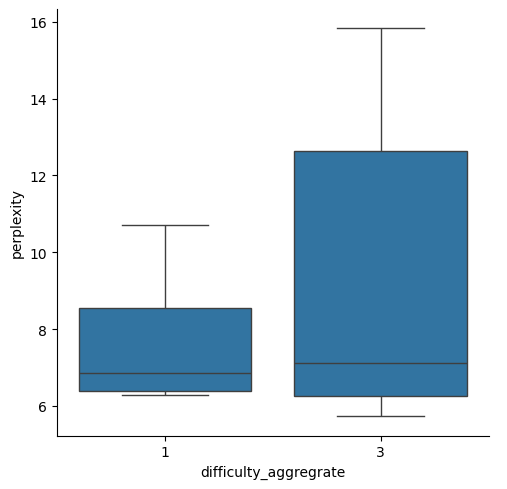

In [30]:
# plot each metric at different complexity / difficulty levels
import matplotlib.pyplot as plt
import seaborn as sns
sns.catplot(data=df, x="difficulty_aggregrate", y="perplexity", kind="box")

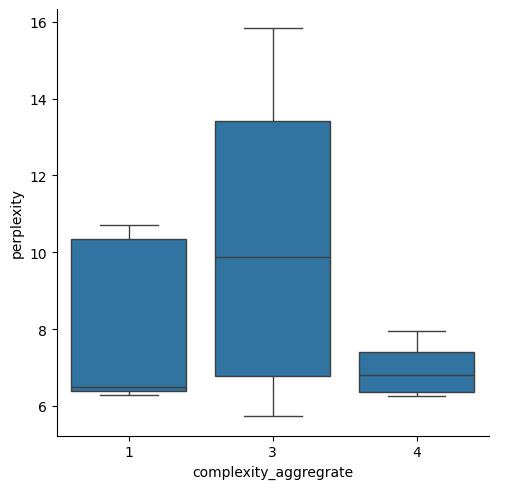

In [31]:
sns.catplot(data=df, x="complexity_aggregrate", y="perplexity", kind="box")

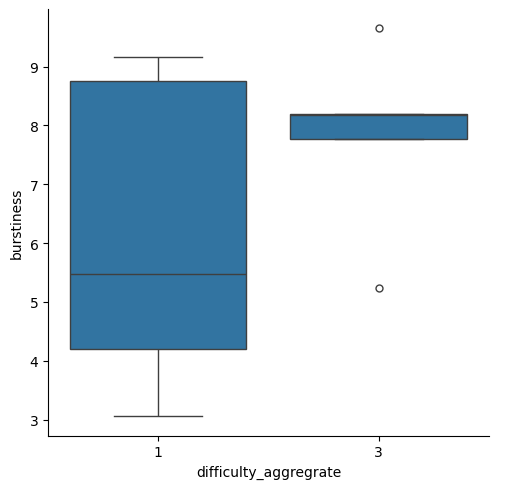

In [32]:
sns.catplot(data=df, x="difficulty_aggregrate", y="burstiness", kind="box")

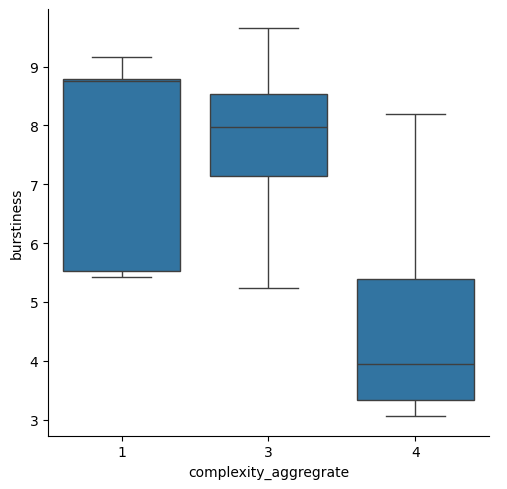

In [33]:
sns.catplot(data=df, x="complexity_aggregrate", y="burstiness", kind="box")

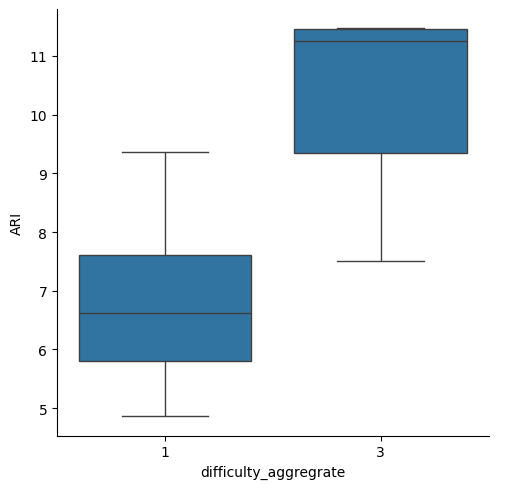

In [34]:
sns.catplot(data=df, x="difficulty_aggregrate", y="ARI", kind="box")

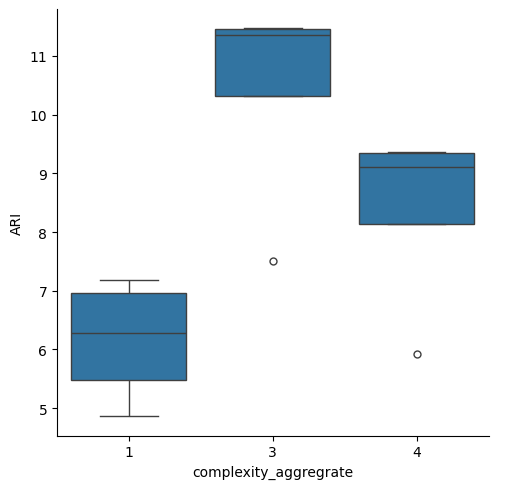

In [35]:
sns.catplot(data=df, x="complexity_aggregrate", y="ARI", kind="box")

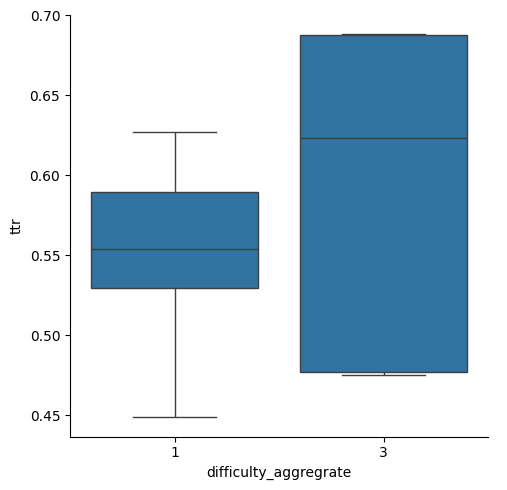

In [36]:
sns.catplot(data=df, x="difficulty_aggregrate", y="ttr", kind="box")

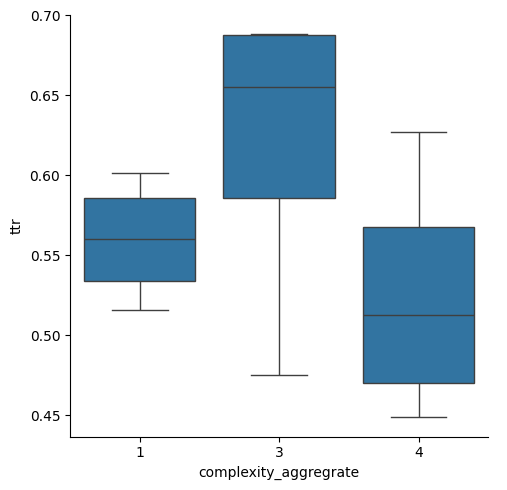

In [37]:
sns.catplot(data=df, x="complexity_aggregrate", y="ttr", kind="box")

In [38]:
df.head(1)

,id,text,Unnamed: 2,complexity_aggregrate,difficulty_aggregrate,label,Comments,perplexity,burstiness,fano_factor,ARI,ttr
0,57227,Rachel is a fitness enthusiast who regularly g...,11,3,3,Reviewed,The issue is very well defined: wanting to wor...,5.730586,5.236553,1.429556,7.513559,0.475


In [65]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
Y = df["complexity_aggregrate"].to_numpy()
X = df[["perplexity","burstiness", "fano_factor", "ARI", "ttr"]].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     2.283
Date:                Thu, 10 Oct 2024   Prob (F-statistic):              0.156
Time:                        16:52:34   Log-Likelihood:                -15.347
No. Observations:                  13   AIC:                             42.69
Df Residuals:                       7   BIC:                             46.08
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5182      2.870      1.226      0.2

/home/aml7990/miniconda3/envs/AIG-CUDA-12.0/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [54]:
Y = df["difficulty_aggregrate"].to_numpy()
X = df[["perplexity", "burstiness", "fano_factor", "ARI", "ttr"]].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     8.105
Date:                Thu, 10 Oct 2024   Prob (F-statistic):            0.00793
Time:                        16:47:38   Log-Likelihood:                -5.6406
No. Observations:                  13   AIC:                             23.28
Df Residuals:                       7   BIC:                             26.67
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7161      1.360      0.526      0.6

/home/aml7990/miniconda3/envs/AIG-CUDA-12.0/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.089
Method:                 Least Squares   F-statistic:                   0.02141
Date:                Thu, 10 Oct 2024   Prob (F-statistic):              0.886
Time:                        16:45:51   Log-Likelihood:                -21.622
No. Observations:                  13   AIC:                             47.24
Df Residuals:                      11   BIC:                             48.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6988      1.161      2.324      0.0

/home/aml7990/miniconda3/envs/AIG-CUDA-12.0/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


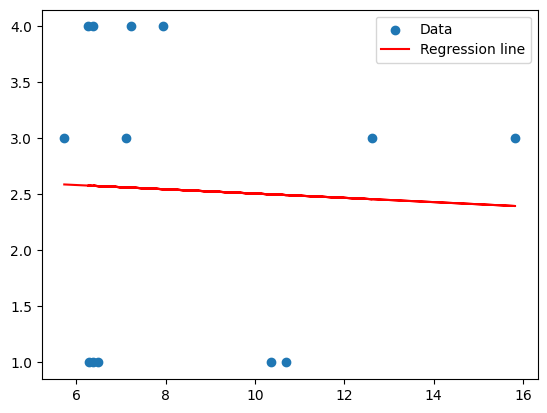

In [52]:
# plot each metric individually
Y = df["complexity_aggregrate"].to_numpy()
# X = df[["perplexity", "burstiness", "fano_factor", "ARI", "ttr"]].to_numpy()
X = df[["perplexity"]].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

plt.scatter(X[:, 1], Y, label='Data')
plt.plot(X[:, 1], model.fittedvalues, 'r', label='Regression line')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     2.493
Date:                Thu, 10 Oct 2024   Prob (F-statistic):              0.143
Time:                        16:48:44   Log-Likelihood:                -20.307
No. Observations:                  13   AIC:                             44.61
Df Residuals:                      11   BIC:                             45.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2196      1.120      3.767      0.0

/home/aml7990/miniconda3/envs/AIG-CUDA-12.0/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


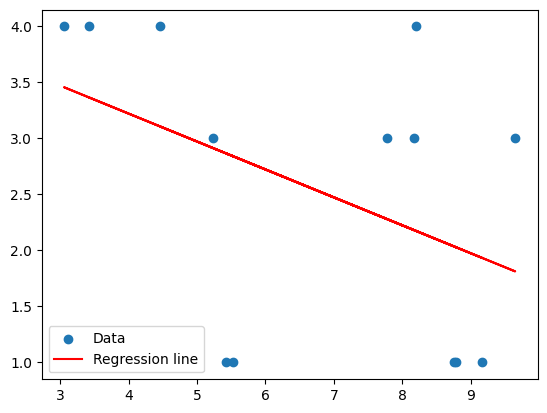

In [55]:
Y = df["complexity_aggregrate"].to_numpy()
# X = df[["perplexity", "burstiness", "fano_factor", "ARI", "ttr"]].to_numpy()
X = df[["burstiness"]].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

plt.scatter(X[:, 1], Y, label='Data')
plt.plot(X[:, 1], model.fittedvalues, 'r', label='Regression line')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     5.108
Date:                Thu, 10 Oct 2024   Prob (F-statistic):             0.0451
Time:                        16:49:14   Log-Likelihood:                -19.155
No. Observations:                  13   AIC:                             42.31
Df Residuals:                      11   BIC:                             43.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7474      0.623      6.020      0.0

/home/aml7990/miniconda3/envs/AIG-CUDA-12.0/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


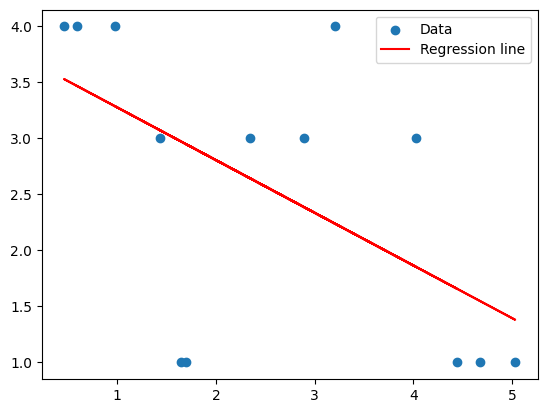

In [56]:
Y = df["complexity_aggregrate"].to_numpy()
# X = df[["perplexity", "burstiness", "fano_factor", "ARI", "ttr"]].to_numpy()
X = df[["fano_factor"]].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

plt.scatter(X[:, 1], Y, label='Data')
plt.plot(X[:, 1], model.fittedvalues, 'r', label='Regression line')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     5.172
Date:                Thu, 10 Oct 2024   Prob (F-statistic):             0.0440
Time:                        16:50:06   Log-Likelihood:                -19.129
No. Observations:                  13   AIC:                             42.26
Df Residuals:                      11   BIC:                             43.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1116      1.208     -0.092      0.9

/home/aml7990/miniconda3/envs/AIG-CUDA-12.0/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


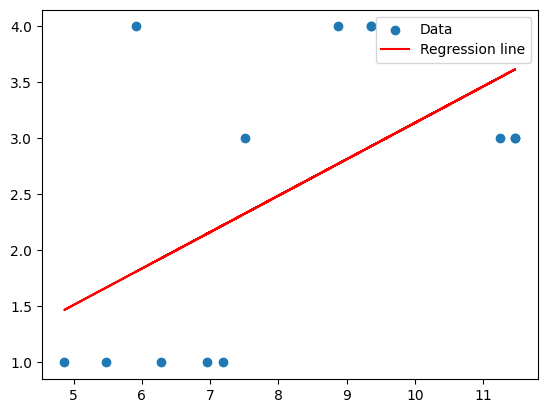

In [57]:
Y = df["complexity_aggregrate"].to_numpy()
# X = df[["perplexity", "burstiness", "fano_factor", "ARI", "ttr"]].to_numpy()
X = df[["ARI"]].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

plt.scatter(X[:, 1], Y, label='Data')
plt.plot(X[:, 1], model.fittedvalues, 'r', label='Regression line')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.085
Method:                 Least Squares   F-statistic:                   0.05990
Date:                Thu, 10 Oct 2024   Prob (F-statistic):              0.811
Time:                        16:50:34   Log-Likelihood:                -21.599
No. Observations:                  13   AIC:                             47.20
Df Residuals:                      11   BIC:                             48.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2540      2.949      1.103      0.2

/home/aml7990/miniconda3/envs/AIG-CUDA-12.0/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


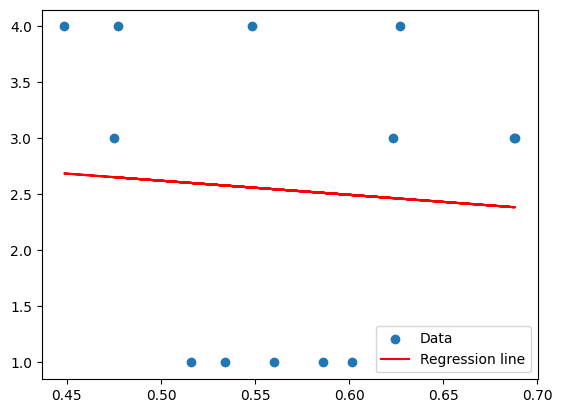

In [59]:
Y = df["complexity_aggregrate"].to_numpy()
# X = df[["perplexity", "burstiness", "fano_factor", "ARI", "ttr"]].to_numpy()
X = df[["ttr"]].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

plt.scatter(X[:, 1], Y, label='Data')
plt.plot(X[:, 1], model.fittedvalues, 'r', label='Regression line')
plt.legend()
plt.show()